## Autonomous system

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from polimi.systems import vdp, vdp_jac, y1min
import polimi.envelope as envelope
from polimi.solvers import *

In [3]:
alpha = 1e-3
gamma = 1e-3
L = 0.1
C = 0.1
# the period of the normalized Van der Pol oscillator
T_norm = 2*np.pi
# the actual period of the Van der Pol oscillator when L and C are taken into account
T = 2*np.pi*np.sqrt(L*C)
n_periods = 5000
epsilon = alpha * np.sqrt(L/C)
print('epsilon = %g' % epsilon)
reltol = 1e-6
abstol = np.array([1e-8,1e-8])
# simulation duration of the normalized system
tend = n_periods*T_norm
v0,w0 = 2e-3,0.
y0 = np.array([v0*np.sqrt(3*gamma/alpha),w0*np.sqrt(3*gamma/alpha)])
method = 'RK45'
if method == 'RK45':
    sol = solve_ivp(lambda t,y: vdp(t,y,epsilon,[0],[1]),[0,tend],y0,
                    method='RK45',atol=abstol,rtol=reltol)
elif method == 'BDF':
    sol = solve_ivp(lambda t,y: vdp(t,y,epsilon,[0],[1]),[0,tend],y0,
                    method='BDF',jac=lambda t,y: vdp_jac(t,y,epsilon),
                    events=y1min,atol=abstol,rtol=reltol)
t_ref = np.sqrt(L*C) * sol['t']
v_ref = np.sqrt(alpha/(3*gamma)) * sol['y'][0]
w_ref = np.sqrt(alpha/(3*gamma)) * sol['y'][1]

epsilon = 0.001


In [4]:
H = 100*T_norm
sol = envelope.envelope_full(lambda t,y: vdp(t,y,epsilon,[0],[1]),[0,tend],y0,T_norm,H,4)
sol['t'] *= np.sqrt(L*C)
sol['y'] *= np.sqrt(alpha/(3*gamma))
sol['T'] *= np.sqrt(L*C)
sol['Z'] *= np.sqrt(alpha/(3*gamma))

R-K iteration #1 +k1 = (0.000002,0.000000)
+k2 = (0.000002,0.000000)
+k3 = (0.000002,0.000000)
+k4 = (0.000002,0.000000)
* done.
R-K iteration #2 +k1 = (0.000002,0.000000)
+k2 = (0.000003,0.000000)
+k3 = (0.000003,0.000000)
+k4 = (0.000003,0.000000)
* done.
R-K iteration #3 +k1 = (0.000003,0.000000)
+k2 = (0.000004,0.000000)
+k3 = (0.000004,0.000000)
+k4 = (0.000004,0.000000)
* done.
After R-K steps.
...............................................


In [5]:
fun = lambda t,y: vdp(t,y,epsilon,[0],[1])
env_fun = lambda t,y: envelope._envelope_system(t,y,fun,T_norm)
fw_eul = forward_euler(env_fun, [0,tend], y0, 100*T_norm)
fw_eul['t'] *= np.sqrt(L*C)
fw_eul['y'] *= np.sqrt(alpha/(3*gamma))
bdf_fixed_step = bdf(env_fun, [0,tend], y0, 100*T_norm, order=4)
bdf_fixed_step['t'] *= np.sqrt(L*C)
bdf_fixed_step['y'] *= np.sqrt(alpha/(3*gamma))

In [6]:
bdf_var_step = solve_ivp(env_fun, [0,tend], y0, method='BDF')
solutions = []
for i in range(len(bdf_var_step['t'])):
    env_t0 = bdf_var_step['t'][i]
    env_y0 = bdf_var_step['y'][:,i]
    #print('%03d/%03d' % (i,len(bdf_var_step['t'])))
    solutions.append(solve_ivp(fun, [env_t0,env_t0+T_norm], env_y0, method='BDF'))
    solutions[-1]['t'] *= np.sqrt(L*C)
    solutions[-1]['y'] *= np.sqrt(alpha/(3*gamma))
bdf_var_step['t'] *= np.sqrt(L*C)
bdf_var_step['y'] *= np.sqrt(alpha/(3*gamma))

In [9]:
envelope = solve_ivp(env_fun, [0,tend], y0, method=envelope.Envelope,
                     period=T_norm, atol=abstol, rtol=reltol)
envelope['t'] *= np.sqrt(L*C)
envelope['y'] *= np.sqrt(alpha/(3*gamma))

KeyboardInterrupt: 

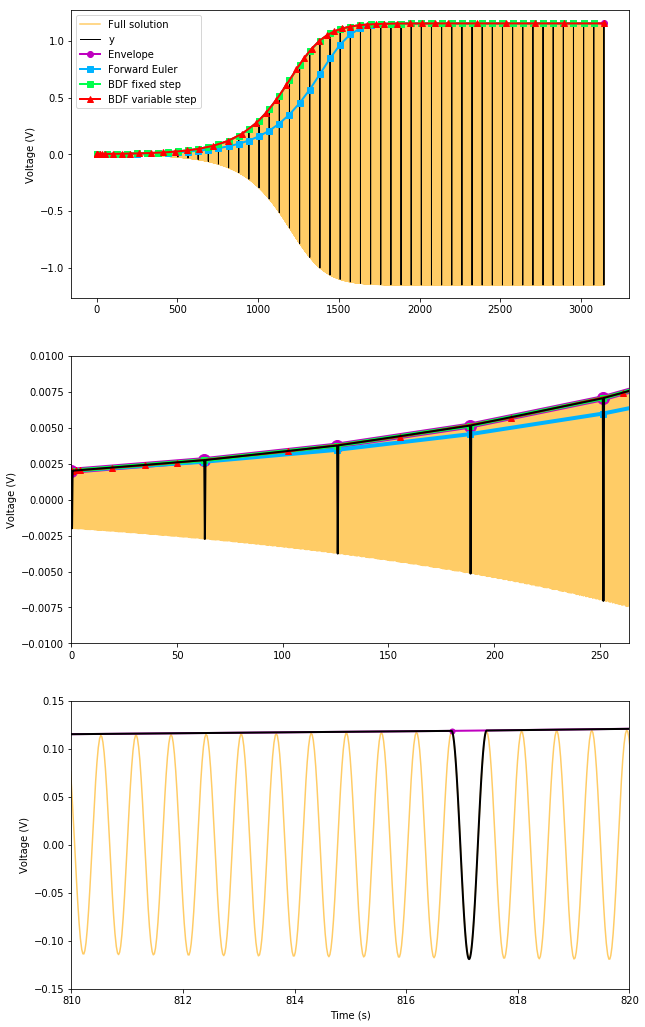

In [7]:
orange = [1,.8,.4]
cyan = [0,.7,1]
green = [0,1,.3]
plt.figure(figsize=(10,18))
plt.subplot(3,1,1)
plt.plot(t_ref,v_ref,color=orange,label='Full solution')
plt.plot(sol['t'],sol['y'][0],'k',lw=1,label='y')
plt.plot(sol['T'],sol['Z'][0],'mo-',lw=2,label='Envelope')
plt.plot(fw_eul['t'],fw_eul['y'][0],'s-',color=cyan,lw=2,label='Forward Euler')
plt.plot(bdf_fixed_step['t'],bdf_fixed_step['y'][0],'s-',color=green,lw=2,label='BDF fixed step')
plt.plot(bdf_var_step['t'],bdf_var_step['y'][0],'^-',color=[1,0,0],lw=2,label='BDF variable step')
#plt.plot(envelope['t'],envelope['y'][0],'v-',color=[.6,.6,.6],lw=2,label='BDF var int step')
plt.ylabel('Voltage (V)')
plt.legend(loc='best')
plt.subplot(3,1,2)
plt.plot(t_ref,v_ref,color=orange)
plt.plot(sol['T'],sol['Z'][0],'mo-',lw=6,markersize=12)
plt.plot(fw_eul['t'],fw_eul['y'][0],'s-',color=cyan,lw=4,label='Forward Euler')
plt.plot(bdf_fixed_step['t'],bdf_fixed_step['y'][0],'s-',color=green,lw=4,label='BDF fixed step')
plt.plot(bdf_var_step['t'],bdf_var_step['y'][0],'^-',color=[1,0,0],lw=2,label='BDF variable step')
#plt.plot(envelope['t'],envelope['y'][0],'v-',color=[.6,.6,.6],lw=2,label='BDF var int step')
plt.plot(sol['t'],sol['y'][0],'k',lw=2)
plt.axis([0,4.2*H*np.sqrt(L*C),-0.01,0.01])
plt.ylabel('Voltage (V)')
plt.subplot(3,1,3)
plt.plot(t_ref,v_ref,color=orange)
plt.plot(sol['T'],sol['Z'][0],'mo-',lw=2,markersize=5)
#plt.plot(fw_eul['t'],fw_eul['y'][0],'s-',color=cyan,lw=4,label='Forward Euler')
#plt.plot(bdf_fixed_step['t'],bdf_fixed_step['y'][0],'s-',color=green,lw=2,label='BDF fixed step')
#plt.plot(bdf_var_step['t'],bdf_var_step['y'][0],'^-',color=[1,0,0],lw=2,label='BDF variable step')
#plt.plot(envelope['t'],envelope['y'][0],'v-',color=[.6,.6,.6],lw=2,label='BDF var int step')
plt.plot(sol['t'],sol['y'][0],'k',lw=2)
#for s in solutions:
#    plt.plot(s['t'],s['y'][0],color=[.5,.5,.5],lw=2)
# plt.xlim(np.array([tend-1.2*H,tend])*np.sqrt(L*C))
plt.axis([810,820,-0.15,0.15])
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()